Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 719ms/step - accuracy: 0.7203 - loss: 0.6581 - val_accuracy: 0.6250 - val_loss: 0.7215
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 684ms/step - accuracy: 0.8684 - loss: 0.3172 - val_accuracy: 0.8125 - val_loss: 0.4053
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 684ms/step - accuracy: 0.8817 - loss: 0.2729 - val_accuracy: 0.8125 - val_loss: 0.6671
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 686ms/step - accuracy: 0.8949 - loss: 0.2562 - val_accuracy: 0.9375 - val_loss: 0.2770
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 680ms/step - accuracy: 0.8980 - loss: 0.2366 - val_accuracy: 0.8750 - val_loss: 0.3534
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 682ms/step - accuracy: 0.9166 - loss: 0.2047 - val_accuracy: 0.7500 - val_loss: 0.4795
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 688ms/step - accuracy: 0.9203 - loss: 0.1998 - val_accuracy: 0.8750 - val_loss: 0.3234
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 672ms/step - accuracy: 0.9201 - loss: 0.20

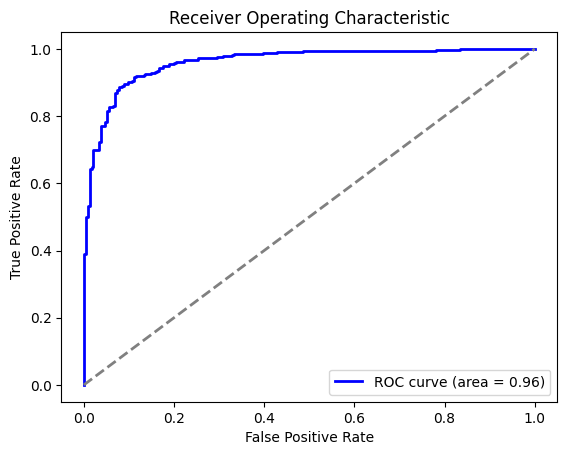

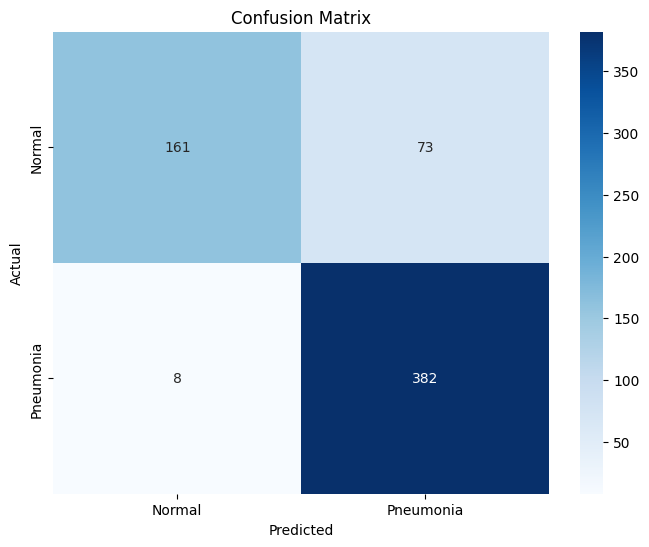

              precision    recall  f1-score   support

      Normal       0.95      0.69      0.80       234
   Pneumonia       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [4]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Define dataset path
dataset_path = '/kaggle/input/x-ray-datasets/chest_Xray'  # Adjust if your dataset path is different

# Define image parameters
IMG_SIZE = (128, 128)  # Adjust based on your dataset's image resolution
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Load validation data
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Define a lightweight CNN model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=50,  # Adjust based on your needs
#     callbacks=[early_stopping]
# )
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20  # Start small, increase if needed
)
# Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_generator)
# print(f'Test Accuracy: {test_acc:.2f}')
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Generate predictions and compute ROC-AUC
y_pred = model.predict(test_generator)
y_true = test_generator.classes

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Compute and plot confusion matrix
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

# Save the model
model.save('/kaggle/working/pneumonia_cnn_model.h5')
